# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [ ]:
!pip install datasets==2.15.0 transformers==4.35.2 accelerate

### Import Packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, Qwen2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional, List, Tuple, Union

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check Devices

In [33]:
!nvidia-smi

Mon Jun 30 11:34:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.04              Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P2             42W /  285W |    2874MiB /  12282MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [2]:
set_seed(0)

# Prepare Data

### Define Dataset

In [3]:
class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        sequence = self.data[idx]
        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels
        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels
        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids
        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [4]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### Visualization

In [37]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    while len(pixel_color) < 400:
        pixel_color.append(0)
    pixel_data = [colormap[pixel] for pixel in pixel_color]
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)
    image = Image.fromarray(image_array)
    return image

def show_images(images: List[Image.Image]) -> None:
    num_images = min(96, len(images))
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

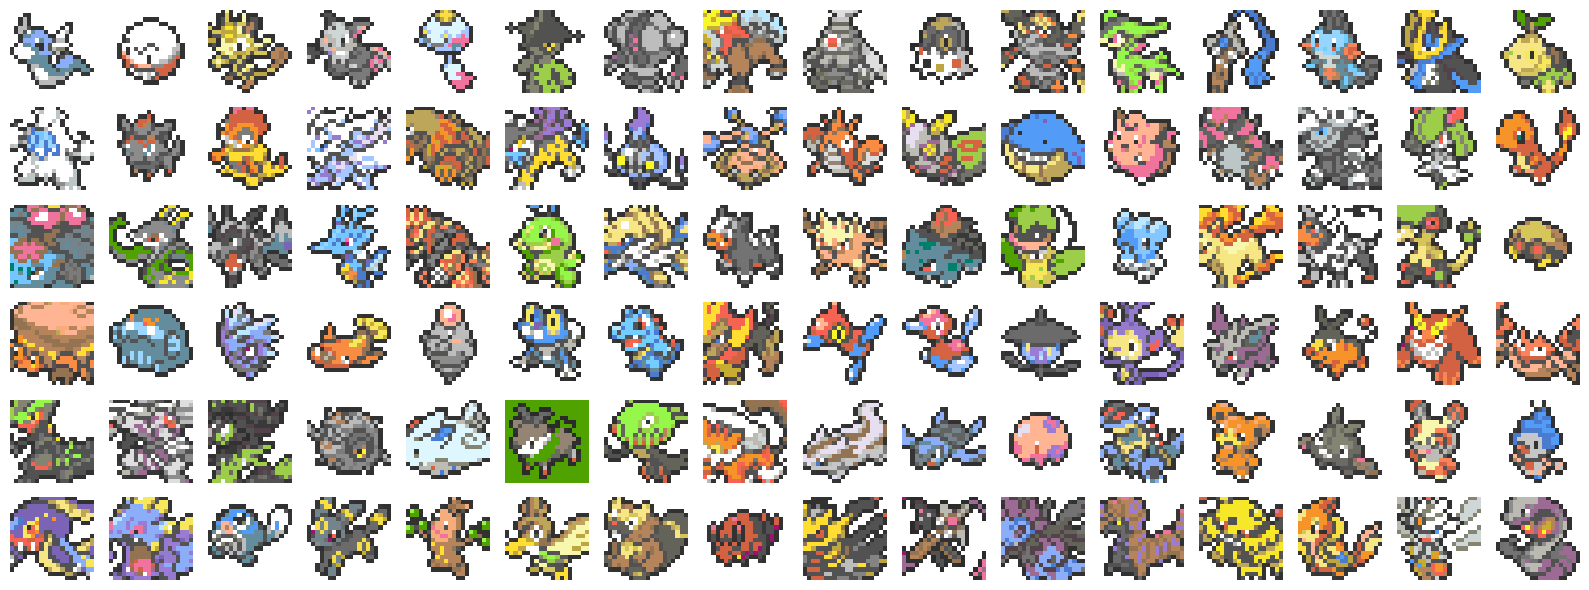

In [38]:
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

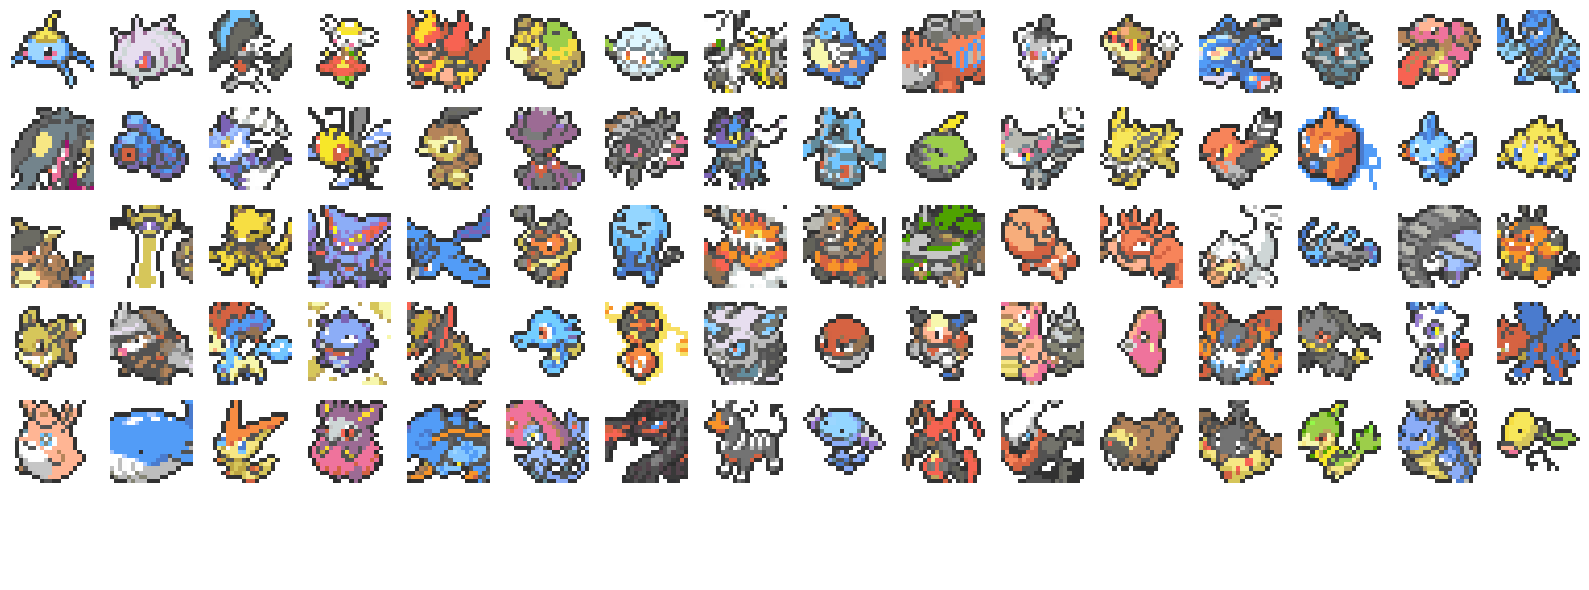

In [55]:
dev_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["dev"]]
output_dir = '/workspace/generated'
for idx, data in enumerate(pokemon_dataset["dev"]):
    img = pixel_to_image(data["pixel_color"], colormap)
    img.save(os.path.join(output_dir, f"{idx:05d}.png"))
show_images(dev_images)

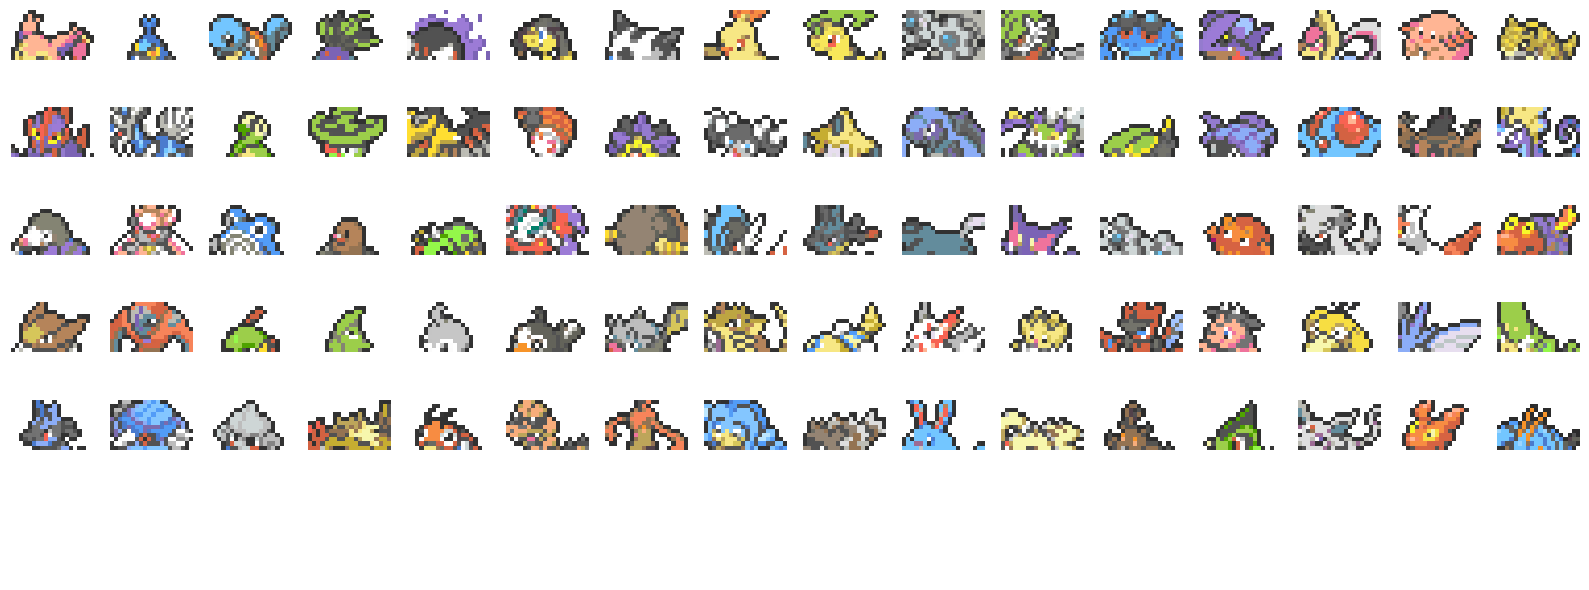

In [39]:
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [5]:
qwen2_config = {
    "vocab_size": num_classes,
    "hidden_size": 384,                 # Larger hidden size for more capacity
    "intermediate_size": 1024,          # Feed-forward layer size
    "num_hidden_layers": 6,             # Deeper model
    "num_attention_heads": 6,           # Number of attention heads
    "num_key_value_heads": 6,           # Standard for Qwen2
    "max_position_embeddings": 400,     # Max sequence length
    "initializer_range": 0.02,
    "rms_norm_eps": 1e-06,
    "use_cache": True,
    "pad_token_id": None,
    "bos_token_id": None,
    "eos_token_id": None,
    "tie_word_embeddings": False,
    "attention_dropout": 0.1,             # Moderate dropout
}

# Load Qwen2 model configuration from dictionary
config = Qwen2Config.from_dict(qwen2_config)

### Load Model

In [6]:
model = AutoModelForCausalLM.from_config(config)
print(model)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params:,}")

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(167, 384)
    (layers): ModuleList(
      (0-5): 6 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=384, out_features=384, bias=True)
          (k_proj): Linear(in_features=384, out_features=384, bias=True)
          (v_proj): Linear(in_features=384, out_features=384, bias=True)
          (o_proj): Linear(in_features=384, out_features=384, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=384, out_features=1024, bias=False)
          (up_proj): Linear(in_features=384, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=384, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((384,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((384,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((384,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbedding

# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

epochs = 50
learning_rate = 3e-4 # Lower learning rate for larger model
grad_clip = 1.0      # Gradient clipping value

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "checkpoints"

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

### Save Model Function

In [43]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, metric: float, save_dir: str, filename: str = "best_model.pth") -> None:
    save_path = os.path.join(save_dir, filename)
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metric_value': metric
    }, save_path)
    print(f"Model saved at {save_path} (Accuracy: {metric:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [44]:
os.makedirs(save_dir, exist_ok=True)
best_accuracy: float = 0.0
model.to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        
        # === FINAL REVISION START: Added Gradient Clipping ===
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        # === FINAL REVISION END ===
        
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

    model.eval()
    total_accuracy = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            attention_mask = torch.ones_like(inputs)
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400, do_sample=False)
            generated_outputs = generated_outputs[:, -160:]
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        save_model(model, optimizer, epoch, best_accuracy, save_dir)


Training Epoch 1/50: 100%|██████████| 40/40 [00:01<00:00, 20.44it/s]


Epoch 1/50, Loss: 3.2642, LR: 0.000300


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 1/50, Reconstruction Accuracy: 0.3605
Model saved at checkpoints/best_model.pth (Accuracy: 0.3605, Epoch: 1)


Training Epoch 2/50: 100%|██████████| 40/40 [00:01<00:00, 22.02it/s]


Epoch 2/50, Loss: 2.4530, LR: 0.000300


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 2/50, Reconstruction Accuracy: 0.2933


Training Epoch 3/50: 100%|██████████| 40/40 [00:01<00:00, 21.90it/s]


Epoch 3/50, Loss: 1.9544, LR: 0.000299


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 3/50, Reconstruction Accuracy: 0.1728


Training Epoch 4/50: 100%|██████████| 40/40 [00:01<00:00, 22.49it/s]


Epoch 4/50, Loss: 1.7033, LR: 0.000297


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 4/50, Reconstruction Accuracy: 0.2713


Training Epoch 5/50: 100%|██████████| 40/40 [00:01<00:00, 22.64it/s]


Epoch 5/50, Loss: 1.5652, LR: 0.000295


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch 5/50, Reconstruction Accuracy: 0.3157


Training Epoch 6/50: 100%|██████████| 40/40 [00:01<00:00, 22.68it/s]


Epoch 6/50, Loss: 1.4683, LR: 0.000293


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 6/50, Reconstruction Accuracy: 0.3561


Training Epoch 7/50: 100%|██████████| 40/40 [00:01<00:00, 22.70it/s]


Epoch 7/50, Loss: 1.4089, LR: 0.000290


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 7/50, Reconstruction Accuracy: 0.3469


Training Epoch 8/50: 100%|██████████| 40/40 [00:01<00:00, 22.50it/s]


Epoch 8/50, Loss: 1.3472, LR: 0.000286


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 8/50, Reconstruction Accuracy: 0.3359


Training Epoch 9/50: 100%|██████████| 40/40 [00:01<00:00, 22.55it/s]


Epoch 9/50, Loss: 1.3022, LR: 0.000282


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 9/50, Reconstruction Accuracy: 0.3480


Training Epoch 10/50: 100%|██████████| 40/40 [00:01<00:00, 22.62it/s]


Epoch 10/50, Loss: 1.2645, LR: 0.000277


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch 10/50, Reconstruction Accuracy: 0.3615
Model saved at checkpoints/best_model.pth (Accuracy: 0.3615, Epoch: 10)


Training Epoch 11/50: 100%|██████████| 40/40 [00:01<00:00, 22.55it/s]


Epoch 11/50, Loss: 1.2121, LR: 0.000271


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 11/50, Reconstruction Accuracy: 0.3376


Training Epoch 12/50: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s]


Epoch 12/50, Loss: 1.1669, LR: 0.000266


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 12/50, Reconstruction Accuracy: 0.3713
Model saved at checkpoints/best_model.pth (Accuracy: 0.3713, Epoch: 12)


Training Epoch 13/50: 100%|██████████| 40/40 [00:01<00:00, 22.54it/s]


Epoch 13/50, Loss: 1.1211, LR: 0.000259


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 13/50, Reconstruction Accuracy: 0.3587


Training Epoch 14/50: 100%|██████████| 40/40 [00:01<00:00, 22.54it/s]


Epoch 14/50, Loss: 1.0875, LR: 0.000253


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 14/50, Reconstruction Accuracy: 0.3809
Model saved at checkpoints/best_model.pth (Accuracy: 0.3809, Epoch: 14)


Training Epoch 15/50: 100%|██████████| 40/40 [00:01<00:00, 22.43it/s]


Epoch 15/50, Loss: 1.0342, LR: 0.000246


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 15/50, Reconstruction Accuracy: 0.3452


Training Epoch 16/50: 100%|██████████| 40/40 [00:01<00:00, 22.64it/s]


Epoch 16/50, Loss: 0.9840, LR: 0.000238


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 16/50, Reconstruction Accuracy: 0.3613


Training Epoch 17/50: 100%|██████████| 40/40 [00:01<00:00, 22.74it/s]


Epoch 17/50, Loss: 0.9311, LR: 0.000231


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 17/50, Reconstruction Accuracy: 0.3525


Training Epoch 18/50: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s]


Epoch 18/50, Loss: 0.8732, LR: 0.000223


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 18/50, Reconstruction Accuracy: 0.3602


Training Epoch 19/50: 100%|██████████| 40/40 [00:01<00:00, 22.70it/s]


Epoch 19/50, Loss: 0.8129, LR: 0.000214


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 19/50, Reconstruction Accuracy: 0.3673


Training Epoch 20/50: 100%|██████████| 40/40 [00:01<00:00, 22.66it/s]


Epoch 20/50, Loss: 0.7562, LR: 0.000206


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch 20/50, Reconstruction Accuracy: 0.3759


Training Epoch 21/50: 100%|██████████| 40/40 [00:01<00:00, 22.60it/s]


Epoch 21/50, Loss: 0.6942, LR: 0.000197


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 21/50, Reconstruction Accuracy: 0.3516


Training Epoch 22/50: 100%|██████████| 40/40 [00:01<00:00, 22.55it/s]


Epoch 22/50, Loss: 0.6412, LR: 0.000188


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 22/50, Reconstruction Accuracy: 0.3527


Training Epoch 23/50: 100%|██████████| 40/40 [00:01<00:00, 22.54it/s]


Epoch 23/50, Loss: 0.5820, LR: 0.000179


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 23/50, Reconstruction Accuracy: 0.3679


Training Epoch 24/50: 100%|██████████| 40/40 [00:01<00:00, 22.31it/s]


Epoch 24/50, Loss: 0.5376, LR: 0.000169


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 24/50, Reconstruction Accuracy: 0.3596


Training Epoch 25/50: 100%|██████████| 40/40 [00:01<00:00, 22.46it/s]


Epoch 25/50, Loss: 0.4870, LR: 0.000160


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch 25/50, Reconstruction Accuracy: 0.3568


Training Epoch 26/50: 100%|██████████| 40/40 [00:01<00:00, 22.56it/s]


Epoch 26/50, Loss: 0.4457, LR: 0.000150


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 26/50, Reconstruction Accuracy: 0.3711


Training Epoch 27/50: 100%|██████████| 40/40 [00:01<00:00, 22.46it/s]


Epoch 27/50, Loss: 0.4050, LR: 0.000141


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 27/50, Reconstruction Accuracy: 0.3698


Training Epoch 28/50: 100%|██████████| 40/40 [00:01<00:00, 22.42it/s]


Epoch 28/50, Loss: 0.3650, LR: 0.000132


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Epoch 28/50, Reconstruction Accuracy: 0.3710


Training Epoch 29/50: 100%|██████████| 40/40 [00:01<00:00, 22.35it/s]


Epoch 29/50, Loss: 0.3283, LR: 0.000122


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch 29/50, Reconstruction Accuracy: 0.3738


Training Epoch 30/50: 100%|██████████| 40/40 [00:01<00:00, 22.53it/s]


Epoch 30/50, Loss: 0.2994, LR: 0.000113


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch 30/50, Reconstruction Accuracy: 0.3655


Training Epoch 31/50: 100%|██████████| 40/40 [00:01<00:00, 21.98it/s]


Epoch 31/50, Loss: 0.2719, LR: 0.000104


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 31/50, Reconstruction Accuracy: 0.3639


Training Epoch 32/50: 100%|██████████| 40/40 [00:01<00:00, 22.68it/s]


Epoch 32/50, Loss: 0.2464, LR: 0.000095


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch 32/50, Reconstruction Accuracy: 0.3582


Training Epoch 33/50: 100%|██████████| 40/40 [00:01<00:00, 22.69it/s]


Epoch 33/50, Loss: 0.2238, LR: 0.000087


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 33/50, Reconstruction Accuracy: 0.3598


Training Epoch 34/50: 100%|██████████| 40/40 [00:01<00:00, 22.47it/s]


Epoch 34/50, Loss: 0.2025, LR: 0.000078


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 34/50, Reconstruction Accuracy: 0.3673


Training Epoch 35/50: 100%|██████████| 40/40 [00:01<00:00, 22.31it/s]


Epoch 35/50, Loss: 0.1845, LR: 0.000070


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch 35/50, Reconstruction Accuracy: 0.3598


Training Epoch 36/50: 100%|██████████| 40/40 [00:01<00:00, 22.43it/s]


Epoch 36/50, Loss: 0.1701, LR: 0.000063


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 36/50, Reconstruction Accuracy: 0.3627


Training Epoch 37/50: 100%|██████████| 40/40 [00:01<00:00, 22.57it/s]


Epoch 37/50, Loss: 0.1541, LR: 0.000055


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Epoch 37/50, Reconstruction Accuracy: 0.3702


Training Epoch 38/50: 100%|██████████| 40/40 [00:01<00:00, 22.56it/s]


Epoch 38/50, Loss: 0.1419, LR: 0.000048


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch 38/50, Reconstruction Accuracy: 0.3594


Training Epoch 39/50: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s]


Epoch 39/50, Loss: 0.1324, LR: 0.000042


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Epoch 39/50, Reconstruction Accuracy: 0.3628


Training Epoch 40/50: 100%|██████████| 40/40 [00:01<00:00, 22.38it/s]


Epoch 40/50, Loss: 0.1234, LR: 0.000035


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch 40/50, Reconstruction Accuracy: 0.3616


Training Epoch 41/50: 100%|██████████| 40/40 [00:01<00:00, 22.77it/s]


Epoch 41/50, Loss: 0.1153, LR: 0.000030


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 41/50, Reconstruction Accuracy: 0.3631


Training Epoch 42/50: 100%|██████████| 40/40 [00:01<00:00, 22.26it/s]


Epoch 42/50, Loss: 0.1083, LR: 0.000024


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


Epoch 42/50, Reconstruction Accuracy: 0.3704


Training Epoch 43/50: 100%|██████████| 40/40 [00:01<00:00, 23.08it/s]


Epoch 43/50, Loss: 0.1025, LR: 0.000019


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 43/50, Reconstruction Accuracy: 0.3660


Training Epoch 44/50: 100%|██████████| 40/40 [00:01<00:00, 22.69it/s]


Epoch 44/50, Loss: 0.0996, LR: 0.000015


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


Epoch 44/50, Reconstruction Accuracy: 0.3703


Training Epoch 45/50: 100%|██████████| 40/40 [00:01<00:00, 21.67it/s]


Epoch 45/50, Loss: 0.0961, LR: 0.000011


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch 45/50, Reconstruction Accuracy: 0.3688


Training Epoch 46/50: 100%|██████████| 40/40 [00:01<00:00, 22.15it/s]


Epoch 46/50, Loss: 0.0939, LR: 0.000008


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Epoch 46/50, Reconstruction Accuracy: 0.3685


Training Epoch 47/50: 100%|██████████| 40/40 [00:01<00:00, 22.63it/s]


Epoch 47/50, Loss: 0.0930, LR: 0.000006


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch 47/50, Reconstruction Accuracy: 0.3735


Training Epoch 48/50: 100%|██████████| 40/40 [00:01<00:00, 22.19it/s]


Epoch 48/50, Loss: 0.0909, LR: 0.000004


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 48/50, Reconstruction Accuracy: 0.3765


Training Epoch 49/50: 100%|██████████| 40/40 [00:01<00:00, 22.39it/s]


Epoch 49/50, Loss: 0.0911, LR: 0.000002


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch 49/50, Reconstruction Accuracy: 0.3684


Training Epoch 50/50: 100%|██████████| 40/40 [00:01<00:00, 22.57it/s]


Epoch 50/50, Loss: 0.0908, LR: 0.000001


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

Epoch 50/50, Reconstruction Accuracy: 0.3686


### Inference

In [45]:
best_model_path = os.path.join(save_dir, "best_model.pth")
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

results: list = []

with torch.no_grad():
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)
        attention_mask = torch.ones_like(inputs)
        generated_outputs = model.generate(
            inputs, 
            attention_mask=attention_mask, 
            max_length=400, 
            do_sample=True, 
            top_k=50,
            top_p=0.95,
            temperature=1.0
        )
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)

output_file: str = "/workspace/reconstructed_results.txt"
with open(output_file, "w") as f:
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")

Generating Outputs: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

Reconstructed results saved to /workspace/reconstructed_results.txt


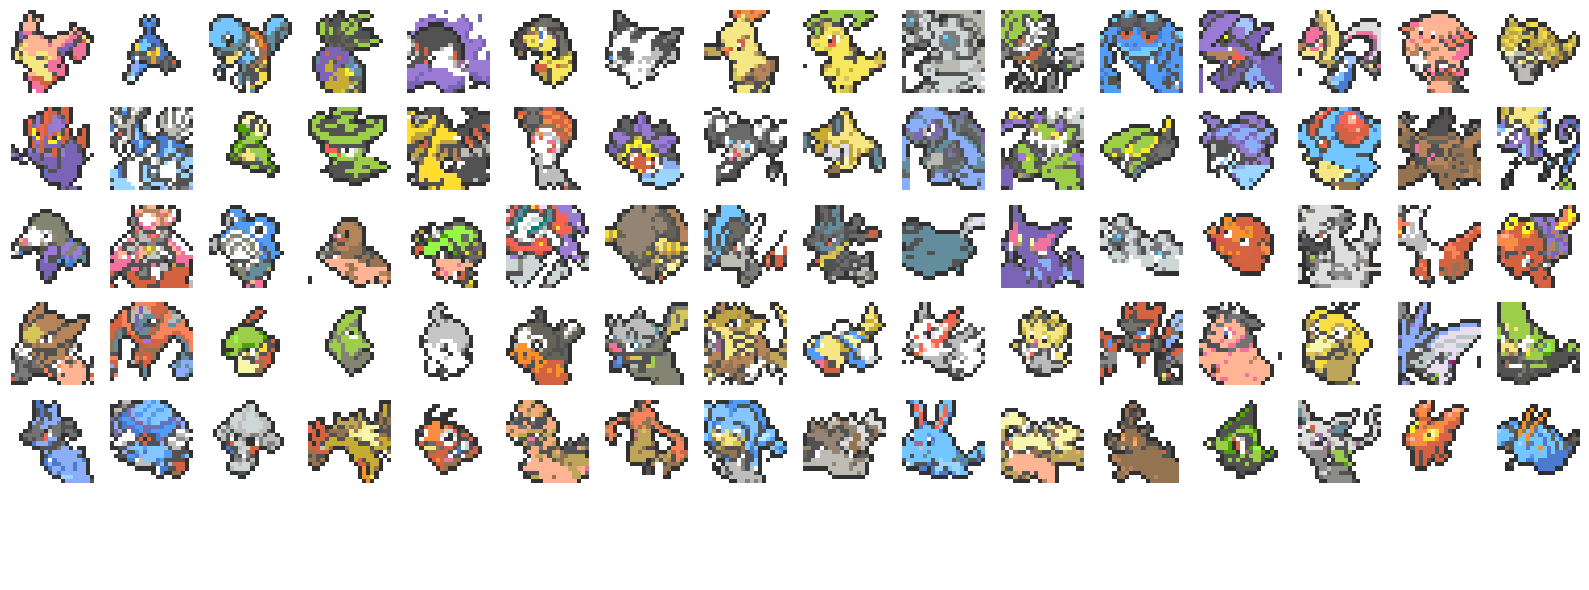

In [46]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)